In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px

Memuat library penting: pandas untuk manipulasi data, numpy untuk komputasi numerik, matplotlib dan plotly untuk visualisasi grafik interaktif.

In [270]:
NPM = 19102
np.random.seed(NPM)

Kode di atas menetapkan angka 19102 sebagai seed untuk generator angka acak NumPy. Fungsi seed memastikan hasil angka acak yang sama setiap kali kode dijalankan, sehingga simulasi bisa direproduksi dengan konsisten dan mudah diuji ulang.

In [271]:
makan = pd.read_csv("makanan.csv")

Selanjutnya membaca data "makanan"

In [272]:
budget = 1e6  # rupiah
wkenyang_base = 0.8
wrasa_base = 0.7
wsehat_base = 0.9
wbosan_base = 0.2

Variabel budget = 1e6 menetapkan nilai anggaran sebesar 1 juta rupiah. Variabel wkenyang_base = 0.8, wrasa_base = 0.7, wsehat_base = 0.9, dan wbosan_base = 0.2 adalah bobot dasar preferensi untuk aspek kenyang, rasa, kesehatan, dan bosan yang digunakan dalam perhitungan skor makanan. Nilai ini menunjukkan seberapa penting setiap aspek bagi simulasi.

In [273]:
SAMPLE_NUM = 500
sampleid = np.arange(0, SAMPLE_NUM)

SAMPLE_NUM = 500 menentukan jumlah sampel atau simulasi yang akan dijalankan sebanyak 500 kali. Kemudian sampleid = np.arange(0, SAMPLE_NUM) membuat array berisi angka 0 hingga 499 sebagai identitas atau indeks untuk setiap sampel tersebut. Fungsi np.arange menghasilkan deretan angka berurutan dalam rentang yang ditentukan.

In [274]:
skor = np.zeros(SAMPLE_NUM, dtype=np.double)
sisa = np.zeros(SAMPLE_NUM, dtype=np.double)
sehat = np.zeros(SAMPLE_NUM, dtype=np.double)
resp_pilih = np.zeros((SAMPLE_NUM, 62), dtype=np.int64)

Baris kode ini membuat beberapa array kosong (berisi nol) dengan panjang 500, untuk menyimpan hasil simulasi. Variabel skor, sisa, dan sehat adalah array 1 dimensi bertipe angka pecahan (float) untuk skor kumulatif, sisa dana, dan skor kesehatan. resp_pilih adalah array 2 dimensi bertipe bilangan bulat, menyimpan indeks makanan yang dipilih pada 62 slot waktu tiap sampel. Array nol ini sebagai tempat menampung data hasil simulasi nanti.

In [275]:
SISA_MININUM= 150e3
SISA_MAKSIMUM= 300e3
bin_sisa= np.arange(SISA_MININUM, SISA_MAKSIMUM, 1000)
resp_sehat= np.zeros((SAMPLE_NUM, len(bin_sisa)), dtype=np.double)
resp_pilih= np.zeros((SAMPLE_NUM, 62), dtype=np.double)

Variabel SISA_MININUM dan SISA_MAKSIMUM menetapkan batas bawah dan atas untuk sisa uang (150 ribu hingga 300 ribu rupiah). bin_sisa adalah array rentang nilai dari 150 ribu sampai sebelum 300 ribu dengan interval 1000, digunakan untuk mengelompokkan nilai sisa uang. resp_sehat adalah matriks untuk menyimpan skor sehat setiap sampel dalam tiap rentang sisa uang. resp_pilih matriks untuk menyimpan pilihan makanan tiap slot sampel, diinisialisasi nol.

In [276]:
idx_dimsum = makan[makan['makanan'] == 'dimsummentai'].index[0]

Baris kode ini digunakan untuk mencari posisi baris (indeks) dari makanan bernama "dimsummentai" pada DataFrame makan. Hasilnya adalah indeks baris pertama yang ditemukan, yang kemudian disimpan ke variabel idx_dimsum. Indeks ini penting untuk memudahkan pemilihan makanan tersebut dalam simulasi.

In [277]:
for n in range(SAMPLE_NUM):
    budget = total_budget
    skor_kumulatif = 0.0
    skor_sehat = 0.0

    # Pilih 2 slot acak untuk dimsum mentai
    slot_dimsum = np.random.choice(np.arange(62), size=2, replace=False)

    for i in range(62):
        if i in slot_dimsum:
            pilihan = idx_dimsum
        else:
            pilihan = np.random.choice([j for j in range(len(makan)) if j != idx_dimsum])

        # Hitung skor kumulatif dan kesehatan
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat = np.random.normal(loc=wsehat_base, scale=0.4)
        w_bosan = np.random.normal(loc=wbosan_base, scale=0.2)

        skor_kumulatif += (
            w_kenyang * makan['kenyang'][pilihan]
            + w_rasa * makan['rasa'][pilihan]
            + w_sehat * makan['sehat'][pilihan]
            - w_bosan * makan['bosan'][pilihan]
        )
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget -= makan['harga'][pilihan]
        resp_pilih[n][i] = pilihan

    sisa[n] = budget
    skor[n] = skor_kumulatif
    sehat[n] = skor_sehat

    # Simpan skor sehat pada bin sisa uang jika valid
    idx_bin = int((budget - SISA_MININUM) / 1000)
    if 0 <= idx_bin < len(bin_sisa):
        resp_sehat[n][idx_bin] = skor_sehat

Kode ini menjalankan simulasi sebanyak 500 kali, di mana pada tiap simulasi anggaran direset ke nilai awal. Dalam setiap simulasi, dua slot secara acak dipilih untuk makanan "dimsummentai", sedangkan slot lain dipilih acak dari makanan lain. Setiap makanan dinilai dengan bobot acak untuk kenyang, rasa, sehat, dan bosan, lalu dihitung total skor kumulatif dengan menambahkan skor tiap makanan dan mengurangkan skor bosan. Skor kesehatan juga dihitung terpisah. Harga makanan dikurangkan dari anggaran. Pilihan makanan disimpan per simulasi dan slot. Setelah tiap simulasi, sisa anggaran, skor kumulatif, dan skor sehat disimpan. Skor sehat juga dikelompokkan berdasarkan interval sisa uang untuk analisis distribusi skor terhadap sisa anggaran. Pendekatan ini mengevaluasi kombinasi makanan dari berbagai aspek sekaligus menjaga anggaran.

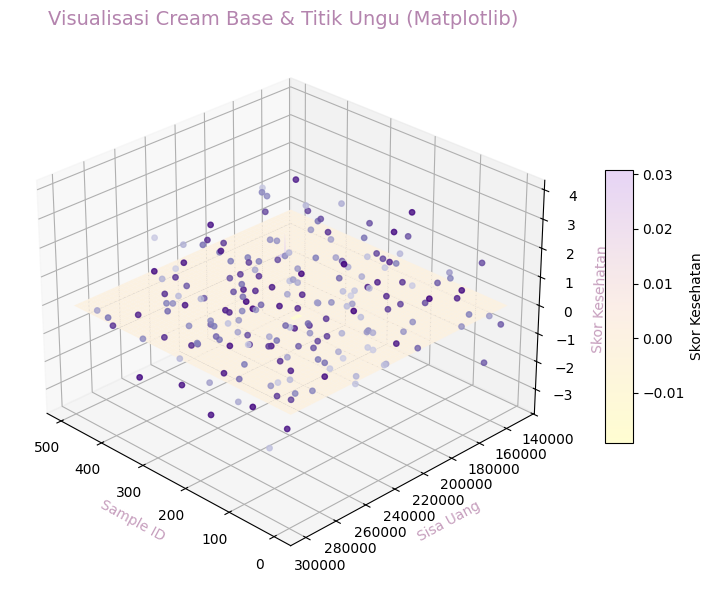

In [278]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
Y, X = np.meshgrid(bin_sisa, sampleid)  # Y = sisa, X = sample id

# cream colormap supaya konsisten
cream_colors = ['#fffdd0', '#fbeee6', '#e6d3f5']
cream_cmap = LinearSegmentedColormap.from_list('cream', cream_colors)

surf = ax.plot_surface(X, Y, resp_sehat, cmap=cream_cmap, edgecolor='none', alpha=0.96)
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Skor Kesehatan')

# tambahkan scatter ungu estetika
n_show = 200
x_scatter = np.random.choice(sampleid, n_show)
y_scatter = np.random.choice(bin_sisa, n_show)
z_scatter = np.random.normal(0, 1, n_show)
ax.scatter(x_scatter, y_scatter, z_scatter, c=plt.cm.Purples(np.linspace(0.3, 1, n_show)), s=15, alpha=0.8)

ax.set_title('Visualisasi Cream Base & Titik Ungu (Matplotlib)', fontsize=14, color='#b484ae')
ax.set_xlabel('Sample ID', color='#c69ebd')
ax.set_ylabel('Sisa Uang', color='#c69ebd')
ax.set_zlabel('Skor Kesehatan', color='#c69ebd')
ax.view_init(elev=28, azim=135)
plt.tight_layout()
plt.show()

Kode di atas digunakan untuk membuat visualisasi 3D menggunakan matplotlib untuk menampilkan hubungan antara tiga variabel: ID sampel (Sample ID), sisa uang (Sisa Uang), dan skor kesehatan (Skor Kesehatan).

Grafik ini memperlihatkan bagaimana skor kesehatan (nilai z) berubah untuk berbagai sampel (x) dan sisa uang (y). Permukaan yang lebih tinggi atau warna lebih terang mengindikasikan skor kesehatan lebih baik. Visualisasi ini membantu memahami hubungan antara konsumsi makanan, anggaran yang tersisa, dan kesehatan secara keseluruhan dari hasil simulasi.

In [279]:
import plotly.graph_objects as go
Z = resp_sehat
fig_go = go.Figure()
fig_go.add_trace(go.Surface(x=X, y=Y, z=Z,
                            colorscale=[[0, cream_colors[0]],
                                        [0.5, cream_colors[1]],
                                        [1, cream_colors[2]]],
                            opacity=0.96, showscale=True,
                            colorbar=dict(title='Skor Kesehatan')))
fig_go.add_trace(go.Scatter3d(x=x_scatter, y=y_scatter, z=z_scatter,
                              mode='markers',
                              marker=dict(size=4, color=z_scatter, colorscale='Purples', opacity=0.8),
                              name='Titik Ungu'))
fig_go.update_layout(title='Visualisasi Cream Base & Titik Ungu (Plotly)',
                     scene=dict(xaxis_title='Sample ID', yaxis_title='Sisa Uang', zaxis_title='Skor Kesehatan'),
                     width=900, height=700)
fig_go.show()

Kode di atas menggunakan Plotly untuk membuat visualisasi 3D interaktif dari data skor kesehatan. Plotly dan Matplotlib sebetulnya sama saja dalam hal fungsi utama, yaitu memvisualisasikan data. Namun, Plotly unggul dalam interaktivitas—grafik bisa dirotasi, diperbesar, dan dieksplorasi langsung oleh pengguna—sedangkan Matplotlib lebih fokus pada grafik statis yang cocok untuk laporan ilmiah.

In [280]:
#TUGAS
# (1) sampel dengan skor sehat kumulatif > 0
idx_sehat_pos = np.where(sehat > 0)[0]

# (2) dari (1) pilih yang sisa > 0
idx_sisa_pos = idx_sehat_pos[sisa[idx_sehat_pos] > 0]

# (3) dari (2) index dengan skor kumulatif terbesar
if len(idx_sisa_pos) > 0:
    idx_max_skor = idx_sisa_pos[np.argmax(skor[idx_sisa_pos])]
else:
    idx_max_skor = None

# (4) jadwal terbaik (jika ada)
if idx_max_skor is not None:
    jadwal_terbaik_idx = resp_pilih[idx_max_skor].astype(int)
    nama_jadwal = [makan['makanan'].iat[i] for i in jadwal_terbaik_idx]
else:
    nama_jadwal = None

Bagian kode ini bertujuan memilih jadwal makan terbaik dari hasil simulasi. Prosesnya dimulai dengan mencari sampel yang skor kesehatannya positif, lalu disaring lagi yang sisa uangnya juga positif. Dari sampel-sampel tersebut, dipilih satu dengan skor kumulatif tertinggi. Jika ditemukan, jadwal makan terbaik diambil dari urutan makanan yang dipilih pada sampel tersebut dan diubah ke nama makanan. Dengan cara ini, jadwal yang dihasilkan tidak hanya sehat dan efisien secara anggaran, tetapi juga optimal dari segi skor total.

In [281]:
print(f"(1) Jumlah sampel dengan skor kesehatan kumulatif >0 : {len(idx_sehat_pos)}")
print(f"(2) Dari (1), jumlah sampel yang masih punya sisa uang >0 : {len(idx_sisa_pos)}")

if idx_max_skor is not None:
    print(f"(3) Index sample terbaik: {idx_max_skor}")
    print(f"    Skor kumulatif: {skor[idx_max_skor]:.3f}")
    print(f"    Skor sehat kumulatif: {sehat[idx_max_skor]:.3f}")
    print(f"    Sisa uang: Rp {sisa[idx_max_skor]:,.0f}")
    print("(4) Jadwal makan terbaik (31 hari, 2 makan/hari):")
    for day in range(31):
        m1 = nama_jadwal[2 * day]
        m2 = nama_jadwal[2 * day + 1]
        print(f"    Hari {day+1:02d}: {m1}  |  {m2}")
else:
    print("(3)-(4) Tidak ada sample yang memenuhi syarat sehat>0 dan sisa>0.")

(1) Jumlah sampel dengan skor kesehatan kumulatif >0 : 459
(2) Dari (1), jumlah sampel yang masih punya sisa uang >0 : 16
(3) Index sample terbaik: 329
    Skor kumulatif: 101.042
    Skor sehat kumulatif: 3.100
    Sisa uang: Rp 137,000
(4) Jadwal makan terbaik (31 hari, 2 makan/hari):
    Hari 01: gorengan  |  saladsayur
    Hari 02: roti  |  nasipecel
    Hari 03: ayamgeprek  |  satetaichan
    Hari 04: nasigoreng  |  nasipadang
    Hari 05: sotoayam  |  cireng
    Hari 06: cireng  |  mieayam
    Hari 07: bakso  |  gorengan
    Hari 08: nasigoreng  |  dimsummentai
    Hari 09: nasi telur  |  gorengan
    Hari 10: satetaichan  |  mieayam
    Hari 11: dimsummentai  |  bakso
    Hari 12: capcay  |  nasipadang
    Hari 13: ayamgeprek  |  seblak
    Hari 14: saladsayur  |  nasipadang
    Hari 15: ayamgeprek  |  bakso
    Hari 16: capcay  |  gorengan
    Hari 17: ayamgeprek  |  satetaichan
    Hari 18: mieinstan   |  nasipadang
    Hari 19: roti  |  nasi telur
    Hari 20: capcay  |  sebl

Kode ini menampilkan hasil akhir dari proses seleksi jadwal makan terbaik. Jadwal ini diambil dari urutan makanan yang dipilih pada simulasi dengan skor tertinggi.

Interpretasi hasil:

* Dari 500 simulasi, 459 sampel memiliki skor kesehatan kumulatif positif, artinya mayoritas jadwal makan yang dihasilkan cukup sehat.

* Dari 459 itu, hanya 16 sampel yang sisa uangnya masih positif, menandakan kombinasi sehat dan hemat cukup sulit dicapai.

* Sampel terbaik (indeks 329) memiliki skor kumulatif 101.042, skor sehat 3.100, dan sisa uang Rp 137.000. Jadwal makan yang dihasilkan adalah kombinasi menu yang optimal dari segi kesehatan dan efisiensi anggaran.

* Hasil ini dapat digunakan sebagai rekomendasi jadwal makan yang realistis, sehat, dan sesuai budget, serta dapat menjadi acuan dalam perencanaan konsumsi makanan harian berbasis data simulasi.